In [49]:
from datasets import load_dataset
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from spacy import displacy

##### Take 1 thousand random passages from the FIQA-PL corpus.

In [2]:
seed = 42

In [12]:
ds = load_dataset("clarin-knext/fiqa-pl", "corpus")
df = pd.DataFrame(ds["corpus"])["text"]

In [15]:
df = df.sample(1000, random_state=seed)
df.head()

53007    To samo tutaj... Żadna sieć fast foodów nie ma...
26164    Dowiedz się, dlaczego działa tak, jak jest, za...
56991    Będziesz musiał płacić podatki w Wielkiej Bryt...
36689    > te dwa wydają się być ze sobą powiązane, Tak...
51427    Przeczytałem wiele relacji na ten temat i owsz...
Name: text, dtype: object

In [16]:
fulltext = " ".join(df)

##### Use the lemmatized and sentence split documents
identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence. E.g. the sentenc

In [25]:
nlp = spacy.load("pl_core_news_sm")


def preprocess(text):
    doc = nlp(text)
    return " ".join([" ".join([token.lemma_ for token in sent]) for sent in doc.sents])

In [ ]:
def identify_lemmatized_entities(text):
    doc = nlp(text)
    expressions = []

    current_expression = ""
    for sent in doc.sents:
        for i, token in enumerate(sent):
            if token.text.istitle() and i > 0 and len(token) > 1:
                if current_expression:
                    current_expression += " " + token.lemma_
                else:
                    current_expression = token.lemma_
            elif current_expression:
                lemmatized_tokens = [t.lemma_ for t in nlp(current_expression)]
                if all(lemma.istitle() for lemma in lemmatized_tokens):
                    expressions.append(current_expression)
                current_expression = ""

    return expressions

In [20]:
# Przykład użycia
sample_text = "Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych."
result = identify_lemmatized_entities(sample_text)
print(f"Identified Lemmatized Expressions: {result}")

Identified Lemmatized Expressions: ['Kraków', 'Polska', 'Stany Zjednoczone']


In [29]:
lemmatized_and_sentence_split_text = preprocess(fulltext)
identified_expressions = pd.DataFrame(
    identify_lemmatized_entities(lemmatized_and_sentence_split_text),
    columns=["expression"],
)
identified_expressions.head()

,expression
0,Angelo
1,Angelo_Mozilo
2,Coolidge
3,New Deal
4,Deal


##### Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.


In [38]:
identified_expressions["expression"].value_counts().head(50)

expression
Ciebie               39
Roth                 30
Stany Zjednoczone    29
Internet             22
Amazon               19
Indie                19
S&P                  18
Google               16
Apple                16
Twoją                14
Ameryka              13
Twoich               13
Vanguard             12
Twojej               11
Europa               10
Money                 9
Iran                  9
Jork                  8
Niemcy                8
Rosja                 8
Tesla                 8
Buffett               8
Izrael                8
Fed                   7
Najlepsze             7
Netflix               7
Microsoft             7
Lucasfilm             6
Trump                 6
Facebook              6
Hathaway              6
Rotha                 5
Vốn                   5
Windows               5
Vis                   5
Hiszpania             5
Amerykanin            5
Amazona               5
Johnson Controls      4
Harvard               4
Corp                  4
Bryta

##### Apply the NER from SpaCy to identify the named entities in the same set of documents.

In [ ]:
ner_res = nlp(fulltext)
ners = [(e.text, e.label_) for e in ner_res.ents]

In [ ]:
df_ner = pd.DataFrame(ners, columns=["text", "label"])

In [ ]:
df_ner["text"].value_counts().head(50)

text
USA                      120
IRA                       35
Wielkiej Brytanii         32
ETF                       27
Amazon                    17
Apple                     16
Stanach Zjednoczonych     15
S&P                       14
amerykańskich             14
Amerykanów                14
Google                    14
IRS                       13
Roth                      12
Indiach                   12
Roth IRA                  11
Stany Zjednoczone         11
Whole Foods               11
MBA                       10
UE                        10
Kanadzie                   9
Ameryka                    9
CPA                        9
SEC                        9
amerykańskie               9
amerykańskiego             9
&                          9
HSA                        8
Chiny                      8
Walmart                    8
gdybyś                     7
Amerykanie                 7
OP                         7
Europie                    7
Microsoft                  7
Netflix  

#### Plot the frequency (histogram) of the identified classes.

In [40]:
identified_classes = df_ner["label"].value_counts().head()
identified_classes

label
orgName      820
placeName    702
persName     653
date         238
geogName     115
Name: count, dtype: int64

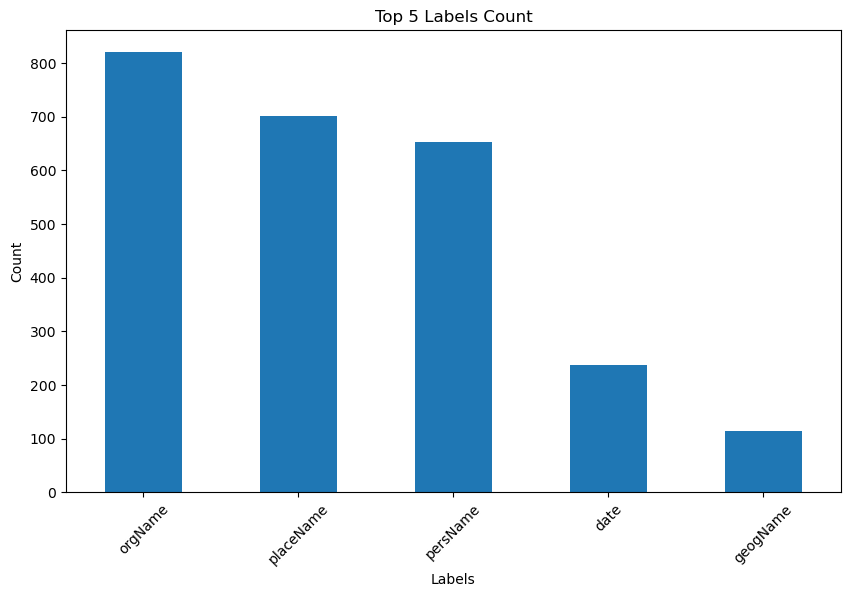

In [43]:
plt.figure(figsize=(10, 6))
identified_classes.plot(kind="bar")
plt.title("Top 5 Labels Count")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

#### Display 10 most frequent Named Entities for each identified type.

In [ ]:
for label in identified_classes.index:
    print(f"Top 10 names for label {label}:")
    print(df_ner[df_ner["label"] == label]["text"].value_counts().head(10))
    print("\n")

Top 10 names for label orgName:
text
IRA            35
ETF            27
Apple          15
S&P            14
IRS            13
Whole Foods    11
Roth IRA       11
Google         10
MBA            10
UE             10
Name: count, dtype: int64


Top 10 names for label placeName:
text
USA                      120
Wielkiej Brytanii         32
Stanach Zjednoczonych     15
Amerykanów                14
amerykańskich             14
Indiach                   12
Stany Zjednoczone         10
amerykańskiego             9
amerykańskie               9
Ameryka                    9
Name: count, dtype: int64


Top 10 names for label persName:
text
Amazon       17
OP            7
Netflix       7
gdybyś        7
Walmart       6
Buffetta      6
musiałbyś     5
Gdybyś        5
Rotha         5
Buffett       4
Name: count, dtype: int64


Top 10 names for label date:
text
10.            7
1099           7
2008 roku      6
2016           6
2014 r.        6
2008 r.        6
2015 r.        6
2012           5
20

##### Display 50 most frequent Named Entities including their count and type.

In [48]:
entity_counts = df_ner.groupby(["text", "label"]).size().reset_index(name="count")
top_50_entities = entity_counts.sort_values(by="count", ascending=False).head(50)
top_50_entities

,text,label,count
1218,USA,placeName,120
632,IRA,orgName,35
1276,Wielkiej Brytanii,placeName,32
424,ETF,orgName,27
158,Amazon,persName,17
1121,Stanach Zjednoczonych,placeName,15
191,Apple,orgName,15
172,Amerykanów,placeName,14
1046,S&P,orgName,14
1345,amerykańskich,placeName,14


##### Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color.

In [ ]:
sentences = nlp(fulltext)
selected_sentences = []
for sent in sentences.sents:
    ents = {ent.label_ for ent in sent.ents}
    if len(ents) >= 2:
        selected_sentences.append(sent)

# 5 sentences
for sentence in selected_sentences[:5]:
    displacy.render(sentence, style="ent", jupyter=True)